In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import scipy.stats as stats
import math
import string
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Make sure data has questions labeled by Letter
# Create a .csv file that contains the mapping of questions to letters

datafile = "finaldata"
questionsfile = "questions"

In [3]:
# Format the data with 1s corresponding to 'OK', 0s corresponding to 'Not OK', delete subjects who didn't answer fully

df = pd.read_csv(datafile + '.csv')
df.dropna(inplace = True)
df = df.replace("I think it's okay to lie here.",1)
df = df.replace("I think it's not okay to lie here.",0)
df["isStraight"] = np.where(df["Orientation"] == 'Heterosexual', 'Straight', 'Not Straight')
df["isMale"] = np.where(df["Gender"] == 'Male', 'Male', 'Not Male')
df["isWhite"] = np.where(df["Race"] == 'White', 'White', 'Not White')
df["isFourth"] = np.where(df["Year"] == 'Fourth', 'Fourth', 'Not Fourth')
df["isAsian"] = np.where(df["Race"] == 'Asian', 'Asian', 'Not Asian')

In [4]:
# Create a dictionary from Letter to text of the survey question
# This is actually a dictionary of one element dictionaries, which isn't ideal but fine for now

qs = pd.read_csv(questionsfile + '.csv')
qsDict = qs.to_dict()

In [5]:
# Given a list of questions, return proportions of OK/Not OKs along with how many said each

def pareByMul(stuff, questions):
    ys = stuff[questions].sum(axis=1).sum()
    tots = (len(questions)*len(stuff))
    ps = ys / tots
    return pd.Series({'OK':ps, 'Not OK':1 - ps, 'Count':(tots/len(questions))})


# Given a list of questions and a list of demographic slices, use pareByMul to see the survey
# responses pared down by demographic data
def look_at(questions, slices):
    return df.groupby(slices).apply(pareByMul, questions)

In [58]:
# Plot the OK/Not OK responses to certain questions, pared down by a certain slice of demographic
# data (Race, Gender, Year, etc.) and comparing specific segments of that demographic, i.e.
# White vs. Asian vs. Black, or Male vs. Female vs. Nonbinary, etc.
# Currently doesn't support multiple-layer analysis, i.e. Black Females vs. White Males

colors = ["steelblue", "#C1403D"]

def chart(questions, slices, segments):
    fig, ax = plt.subplots(1,3, figsize = (12,5))
    fig.suptitle("Do you think it is okay to lie in situation " + str(questions))
    
    data = look_at(questions, slices)
    fullData = pd.DataFrame(pareByMul(df, questions))
    
    for i in range(len(segments)):
        ax[i].pie(data[['OK','Not OK']].transpose()[segments[i]],
                 labels = ['OK', 'Not OK'],
                 colors = colors,
                 autopct='%1.1f%%')
        ax[i].set_title(segments[i] + " (" + 
                        str(int(data.Count[segments[i]]))
                       + ")")
        ax[2].pie(fullData.transpose()[['OK','Not OK']],
                labels = ['OK', 'Not OK'],
                colors = colors,
                autopct='%1.1f%%')
        ax[2].set_title("Total Population (" + str(int(fullData.get_value('Count', 0))) + ")")
    plt.savefig(str(segments) + "_" + str(questions) + ".png") ## this could be done better

# Plot the OK/Not OK responses as above, but do it for all questions at once.        

def all_charts(slices, segments):
    for i in string.ascii_uppercase[:15]:
        chart([i], slices, segments)
        
# Plot the OK/ Not OK responses as above, but do it only for questions where
# the difference in responses was statistically significant
        
def sig_charts(slices, segments, a):
    sig_qs = do_ttests(slices, segments, a)
    print('The difference in responses in the below', str(len(sig_qs)), 'charts were seen to be',
           'statistically significant at an alpha level of', a)
    for i in sig_qs:
        chart([i], slices, segments)

In [7]:
# Welch t-test for comparing differences of group means

def welch_ttest(question, slices, segments, a):
    t, p = stats.ttest_ind(df[df[slices] == segments[0]][question], 
                           df[df[slices] == segments[1]][question], 
                           equal_var=False)
    if p < a:
        return question
    
# Do t-test for all questions, return the questions that are significant with p < a
    
def do_ttests(slices, segments, a):
    significant_qs = []
    for i in string.ascii_uppercase[:15]:
        significant_qs.append(welch_ttest(i, slices, segments, a))
    return list(filter(None, significant_qs))

Uh oh does this violate normality?? Need to figure out more bc then can't do t-test

In [8]:
stats.shapiro(df[df['isMale'] == 'Male']['A'])

(0.2265046238899231, 1.8313958092095895e-20)

The difference in responses in the below 4 charts were seen to be statistically significant at an alpha level of 0.05


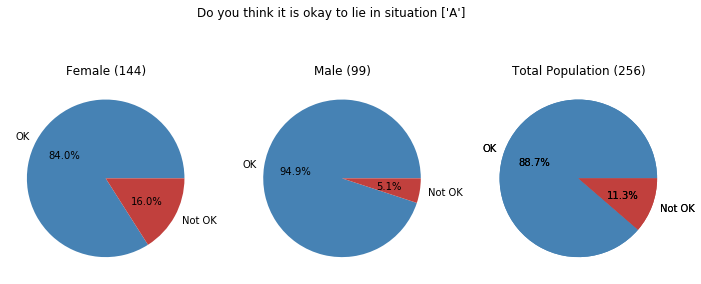

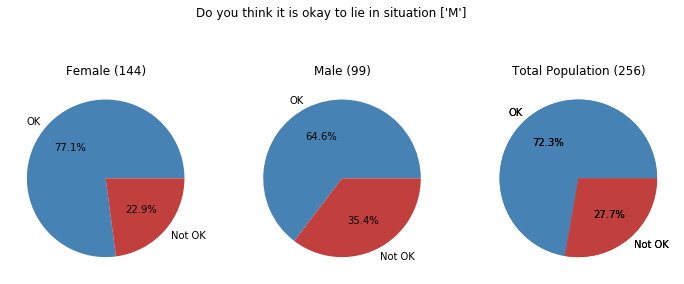

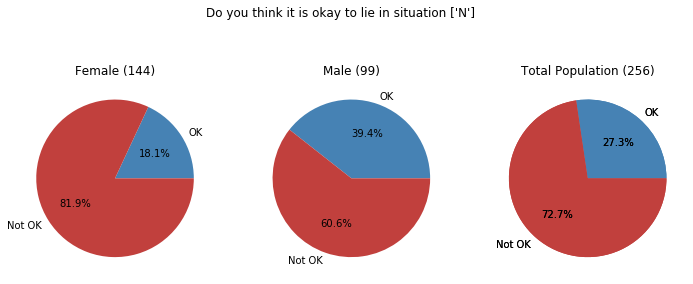

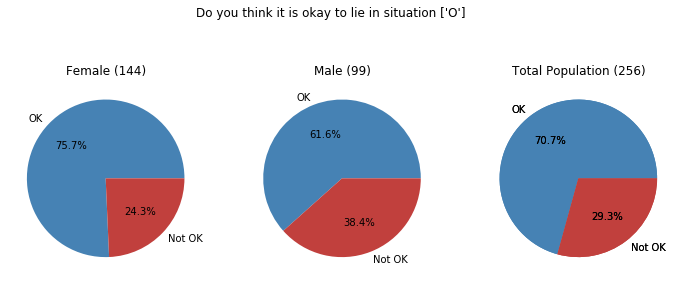

In [65]:
sig_charts('Gender', ['Female', 'Male'], 0.05)